In [ ]:
import tensorflow as tf

print(tf.__version__)

1.15.0-rc3


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


**Extracting the contents:**

In [ ]:
!unzip asl-alphabet.zip

Archive:  asl-alphabet.zip
replace asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Specifying train and test directories:**

In [ ]:
# Specifying the training and test directories

TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

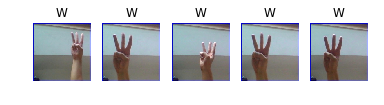

In [ ]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = categories[random.randint(1, 30)]
# category = 'A'

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)

plt.show()

# Preparing the training set

In [ ]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# Preparing the model for training

**Preparing VGG16 Network for transfer learning:**

In [ ]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

# Not required --> inception_v3_model.load_weights(WEIGHTS_FILE)

# Enabling the top 2 inception blocks to train
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1222 (Batch (None, 99, 99, 32)   96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 99, 99, 32)   0           batch_normalization_1222[0][0]   
_______________________________________________________________________________________

In [ ]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
# Not required --> x = layers.Dropout(0.2)(x)
x = layers.Dense(29, activation='softmax')(x)

model = Model(inception_v3_model.input, x)

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
# Watch the new model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1222 (Batch (None, 99, 99, 32)   96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 99, 99, 32)   0           batch_normalization_1222[0][0]   
___________________________________________________________________________________________

**Setting up a callback funtion in order to stop training at a particular threshold:**

In [ ]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

**Fitting the model to the training dataset:**

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 191s 2s/step - loss: 3.3793 - acc: 0.0614 - val_loss: 3.4233 - val_acc: 0.0569
Epoch 2/50
100/100 [==============================] - 152s 2s/step - loss: 3.1502 - acc: 0.1695 - val_loss: 3.1327 - val_acc: 0.1412
Epoch 3/50
100/100 [==============================] - 153s 2s/step - loss: 2.8890 - acc: 0.3264 - val_loss: 2.9388 - val_acc: 0.2616
Epoch 4/50
100/100 [==============================] - 154s 2s/step - loss: 2.5856 - acc: 0.4628 - val_loss: 2.6841 - val_acc: 0.3856
Epoch 5/50
100/100 [==============================] - 154s 2s/step - loss: 2.2664 - acc: 0.5772 - val_loss: 2.4019 - val_acc: 0.4950
Epoch 6/50
100/100 [==============================] - 155s 2s/step - loss: 1.9700 - acc: 0.6530 - val_loss: 2.1017 - val_acc: 0.5903
Epoch 7/50
100/100 [==============================] - 155s 2s/step - loss: 1.6815 - acc: 0.7348 - val_loss: 1.7899 - val_acc: 0.6687
Epoch 8/50
100/100 [==============================] - 154s 2s/step - 

# Plotting the results

**Training Accuracy vs Validation Accuracy:**

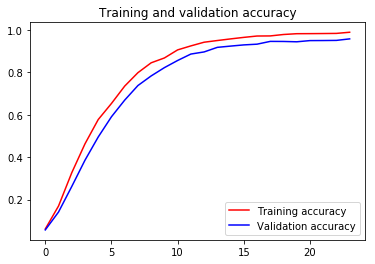

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**Training Loss vs Validation Loss**

<Figure size 432x288 with 0 Axes>

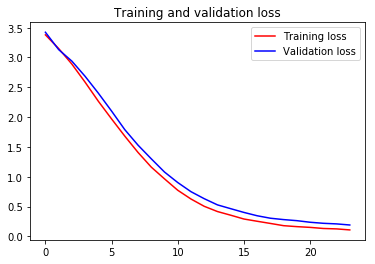

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()